# Characterizing edges

The goal of this notebook is to characterize edges of the UMAP graph with respect with their position (internal/external) in the groundtruth partition. It is also to see if the edges misclassified by Leiden/HDBSCAN partitions have particularities (with their endpoints' rho and sigma values, with the number of supporting triangles, etc.) 

For each point $x_i$ in original space, consider $\{x_{i_1}, \cdots, x_{i_k}\}$ the $k$ the set of $k$ nearest neighbors. Then $\rho_i$ is the distance between $x_i$ and its closest (distinct) neighbour. The value $\sigma_i$ is set so that $\sum_{j=1}^k \exp(\frac{-\max(0, d(x_i, x_{i_j}) - \rho_i)}{\sigma_i}) = \log_2(k)$ for every data point $x_i$. If the distances to neighbors are all concentrated, $\sigma$-value will be larger.

The edge values we consider are: 
* high dimensional distance between the edge's endpoints
* UMAP weight
* Sum of endpoints' $\rho$ and $\sigma$ values - as described above
* Number of triangles in the graph containing this specific edge

In [1]:
!git branch

* main


In [2]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [3]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
from sklearn.neighbors import KNeighborsTransformer
import pynndescent
from scipy.spatial.distance import euclidean

import cdlib.algorithms as cd
import itertools
import collections
import igraph as ig
import leidenalg as la

from community import community_louvain

sns.set()

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'karateclub', 'wurlitzer', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


# Functions

In [55]:
def enrich_graph_edge_properties(G, vertex_high_representation=None, vertex_low_representation=None):
    
    G.es['umap_weight'] = G.es['weight']
    
    simplices = G.cliques(min=3, max=3)
    edge_in_simplex = []
    for x in simplices:
        edge_in_simplex += G.get_eids([pair for pair in itertools.combinations(x, r=2)])
    G.es["nb_triangles"] = 0
    for k, v in collections.Counter(edge_in_simplex).items():
        G.es[k]["nb_triangles"] = v
    
    for e in G.es:
        e['sigma_sum'] = sum([G.vs[e.target]['sigmas'],G.vs[e.source]['sigmas']])
        e['rho_sum'] = sum([G.vs[e.target]['rhos'],G.vs[e.source]['rhos']])
        
    if(vertex_low_representation is not None):
        G.es['lowdim_dist'] = [euclidean( vertex_low_representation[e.source], 
                                         vertex_low_representation[e.target] ) 
                               for e in G.es]
        
    if(vertex_high_representation is not None):
        G.es['highdim_dist'] = [euclidean( vertex_high_representation[e.source], 
                                         vertex_high_representation[e.target] ) 
                               for e in G.es]  
        
    G.es['betweenness'] = [min(10000, x) for x in G.edge_betweenness()]
    return(G)

In [5]:
# Plotting the features using boxes
def barPlot_split_on(what, split_on, edge_df, nb_cols=3):
    print(collections.Counter(edge_df[split_on]))
    nb_rows = int(np.ceil(len(what)/nb_cols))
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(15, 4*nb_rows))
    for i, var in enumerate(what):
        w_row = (i//nb_cols)
        w_col = (i%nb_cols)
        plt.subplot(nb_rows, nb_cols, i+1)
        sns.boxplot(x = split_on, y = var, data = edge_df)
        axes[w_row][w_col].title.set_text(var)
        if(w_row < nb_rows-1):
            plt.xlabel('')
        plt.ylabel('')

In [80]:
# Plotting the features using boxes
def barPlot_split_on2(what, split_on, edge_df, nb_cols=3, log_scale=False):
    print(collections.Counter(edge_df[split_on]))
    nb_rows = int(np.ceil(len(what)/nb_cols))
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(15, 4*nb_rows))
    for i, var in enumerate(what):
        w_row = (i//nb_cols)
        w_col = (i%nb_cols)
        plt.subplot(nb_rows, nb_cols, i+1)
        if(var in ['bi_directional']):
            df = edge_df.groupby([var, split_on]).size().reset_index(name='Count')
            df.loc[df[var], 'Count'] = df[df[var]]['Count']//2
            sns.barplot(x=var, y="Count", data=df, ci=None, hue=split_on)
        else:
            if(max(edge_df[var])<=1):
                sns.histplot(x = var, data = edge_df, hue=split_on, log_scale=log_scale)
            elif(max(edge_df[var])>1000):
                sns.histplot(x = var, data = edge_df, hue=split_on, log_scale=log_scale, bins=50)
            else:
                sns.histplot(x = var, data = edge_df, hue=split_on, log_scale=log_scale, discrete=True)
        # axes[w_row][w_col].title.set_text(var)
        # if(w_row < nb_rows-1):
        #     plt.xlabel('')
        # plt.ylabel('')

# Pendigits clustering scores

Conclusion from empirical study. Standard graph clustering algorithms tend to produce a larger number of parts than HDBSCAN on lower dimensional, and than ground truth. 

In [7]:
dataset_id = 0
set_op_mix_ratio = 1
raw_data, targets, dataset_name = get_dataset(dataset_id)
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')

umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)

G = graph_edge_class_from_labels(G, hd_umap_labels, attribute_name = 'hd_internal')

ec = la.find_partition(G, la.ModularityVertexPartition)
clustering_labels = np.array(ec.membership)
G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')

## Empirical study: edge attributes

For each edge, we have the following attributes:
* 'internal_hd': Internal/external w.r.t. Umap-HDBSCAN clustering (binary)
* 'lowdim_dist': distance between vertices in lower dimension after UMAP reduction
* 'nb_triangles': number of triangles involving that edge (EXPENSIVE!)

The following should really be node attributes, but we stored it as edge by introducing edge directions!
* 'sigma_sum': sum of edge's endpoints sigma values (from UMAP)
* 'rho_sum': sum of edge's endpoints rho values (from UMAP)

In [8]:
G = enrich_graph_edge_properties(G, 
                                 vertex_high_representation=raw_data, 
                                 vertex_low_representation=umap_rep)

In [49]:
edge_df = G.get_edge_dataframe()
edge_df['true_vs_hd'] = list(zip(edge_df.internal, edge_df.hd_internal))
edge_df['true_vs_leiden'] = list(zip(edge_df.internal, edge_df.leiden_internal))
mapping = {(True, True):'True pos', (False, False):'True neg', (True, False):'False neg', (False, True):'False pos'}
edge_df['HDBSCAN'] = [mapping[x] for x in edge_df['true_vs_hd']]
edge_df['Leiden'] = [mapping[x] for x in edge_df['true_vs_leiden']]
edge_df

,source,target,weight,internal,hd_internal,leiden_internal,umap_weight,nb_triangles,sigma_sum,rho_sum,lowdim_dist,highdim_dist,betweenness,true_vs_hd,true_vs_leiden,HDBSCAN,Leiden
edge ID,,,,,,,,,,,,,,,,,
0,0,30,0.166892,True,True,True,0.166892,3,5.323761,26.606928,0.280595,20.784609,19.590155,"(True, True)","(True, True)",True pos,True pos
1,0,276,0.073232,True,True,True,0.073232,12,3.945984,24.145357,0.282539,17.378147,35.263612,"(True, True)","(True, True)",True pos,True pos
2,0,286,0.026902,True,True,True,0.026902,4,3.936890,28.188140,0.252029,22.583179,60.676717,"(True, True)","(True, True)",True pos,True pos
3,0,292,0.021763,True,True,True,0.021763,7,3.452171,29.928117,0.172440,22.781572,169.406222,"(True, True)","(True, True)",True pos,True pos
4,0,328,0.116103,True,True,True,0.116103,8,5.121994,23.161007,0.311092,17.944359,229.331412,"(True, True)","(True, True)",True pos,True pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17114,1786,1792,0.138082,True,True,True,0.138082,3,6.246124,34.246645,0.340824,25.159491,664.646261,"(True, True)","(True, True)",True pos,True pos
17115,1788,1791,0.506212,True,True,True,0.506212,13,6.976440,26.378161,0.194671,17.549929,148.126515,"(True, True)","(True, True)",True pos,True pos
17116,1789,1790,0.848248,True,False,False,0.848248,3,5.388748,43.359209,1.075151,24.596748,107.733247,"(True, False)","(True, False)",False neg,False neg


82


<AxesSubplot:xlabel='nb_triangles', ylabel='Count'>

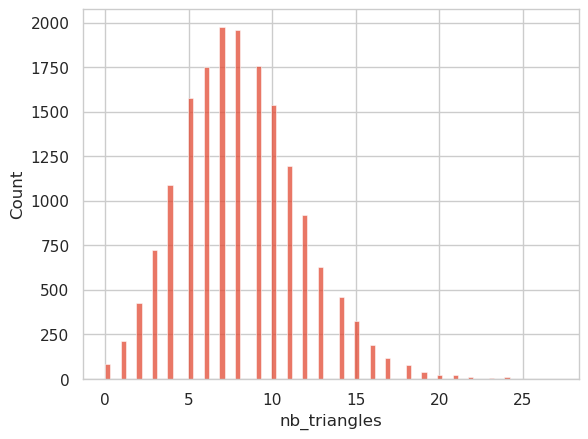

In [10]:
sns.set_style('whitegrid')
print(sum(edge_df.nb_triangles==0))
sns.histplot(edge_df.nb_triangles)

Counter({True: 16136, False: 983})


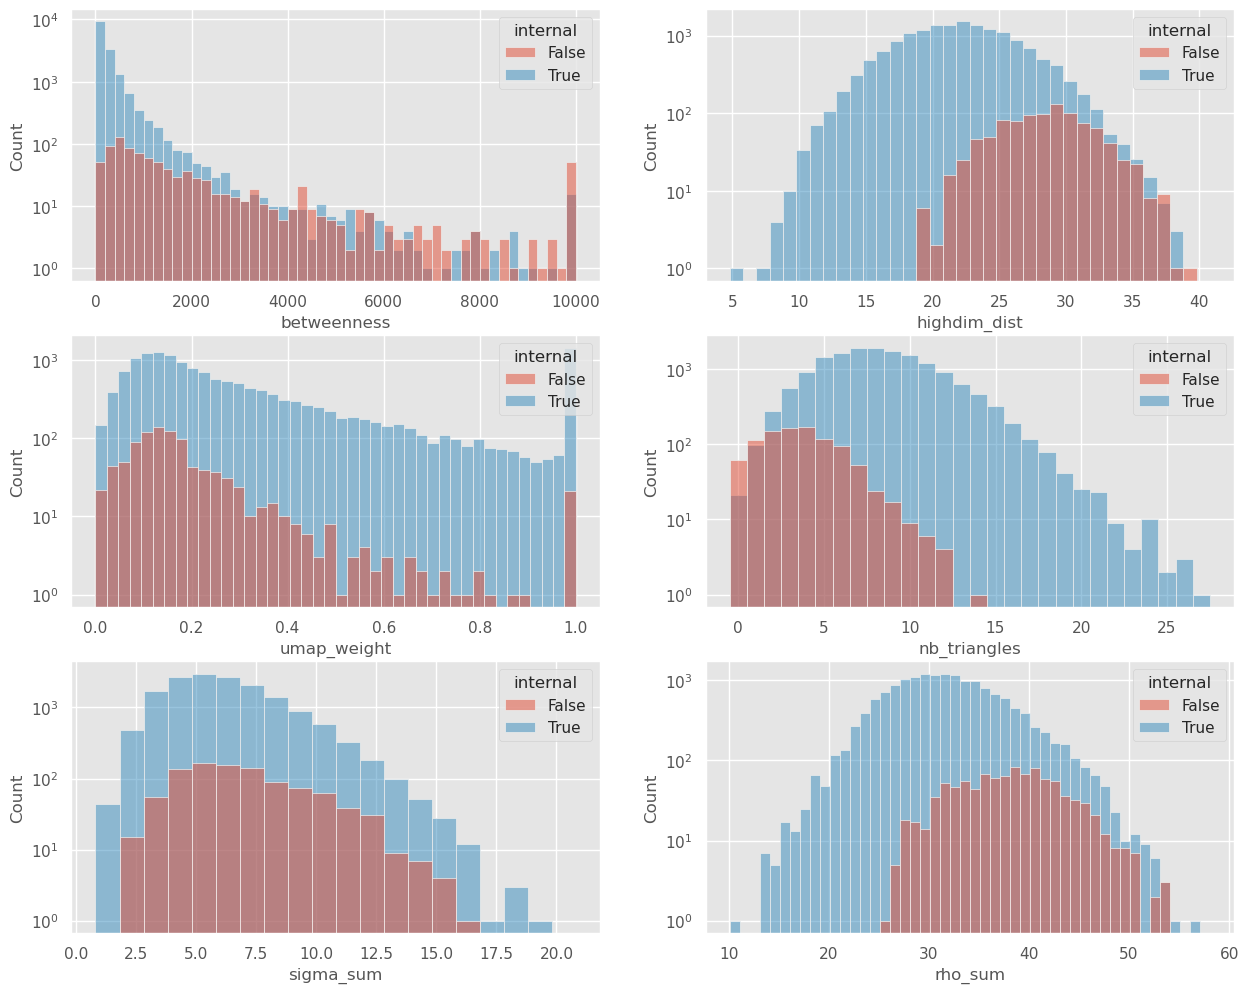

In [69]:
what_vars_to_plot = ['betweenness', 'highdim_dist', 'umap_weight', 'nb_triangles', 'sigma_sum', 'rho_sum']
barPlot_split_on2(what = what_vars_to_plot,
                 split_on='internal', 
                 edge_df=edge_df,
                 log_scale = (False, True),
                  nb_cols=2)

Counter({'True pos': 16025, 'True neg': 725, 'False pos': 258, 'False neg': 111})


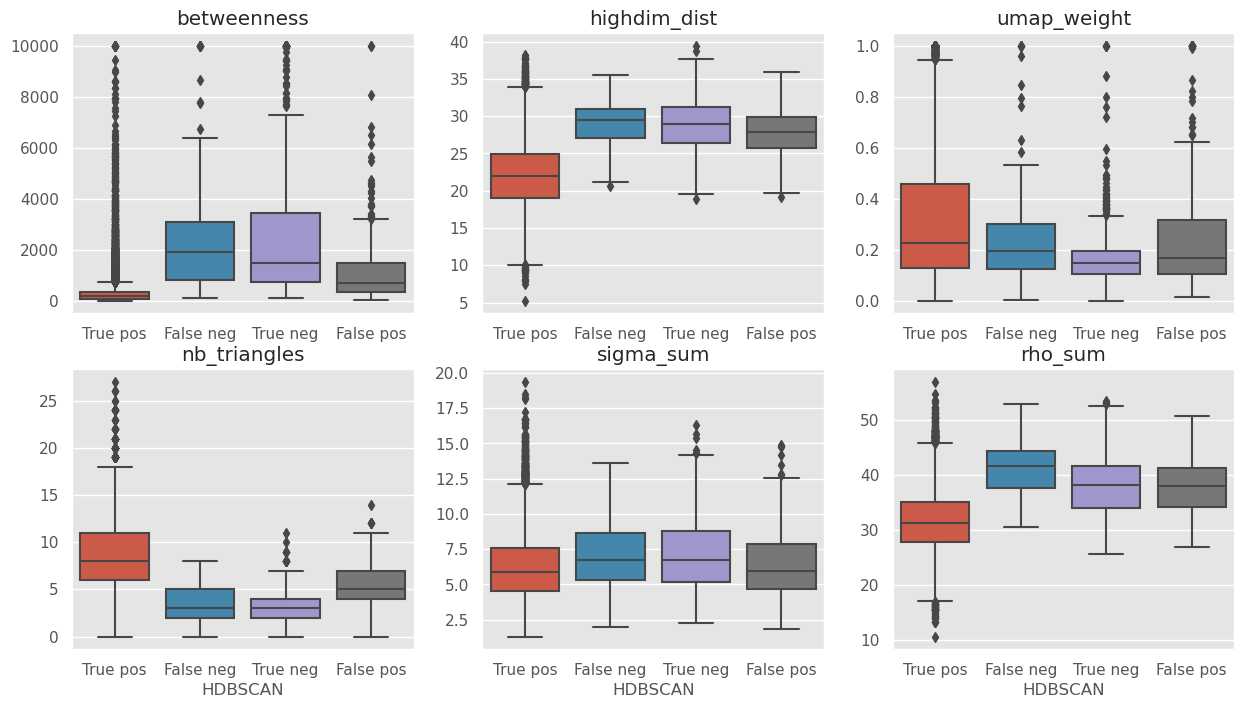

In [58]:
barPlot_split_on(what = what_vars_to_plot,
                 split_on='HDBSCAN', edge_df=edge_df)

Counter({'True pos': 15930, 'True neg': 598, 'False pos': 385, 'False neg': 206})


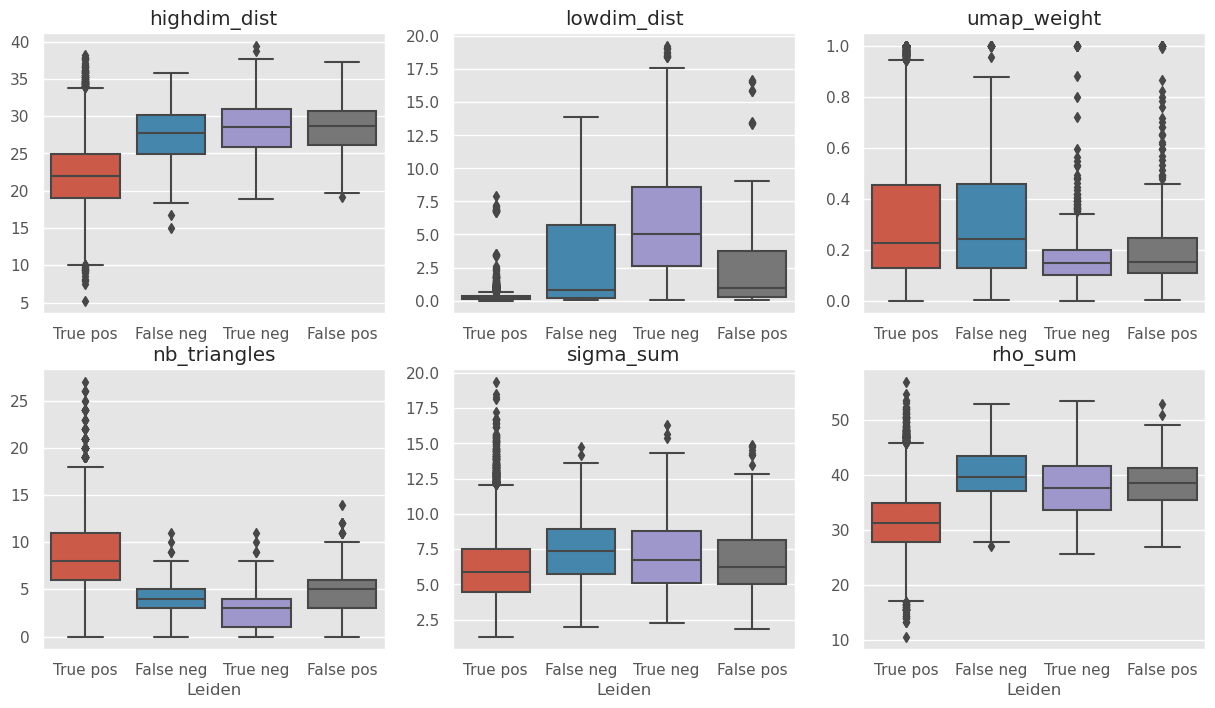

In [13]:
barPlot_split_on(what = what_vars_to_plot,
                 split_on='Leiden', edge_df=edge_df)

# Plot one edge property for all datasets 

In [123]:
# Plotting the features using boxes
def barPlot_split_on3(what, what_data, split_on, edge_df, nb_cols=3, log_scale=False):
    var = what
    datasets = list(set(edge_df))
    nb_rows = int(np.ceil(len(what_data)/nb_cols))
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(15, 4*nb_rows))
    for i, data_name in enumerate(what_data):
        edge_df_tmp = edge_df[edge_df.Name == data_name].copy()
        w_row = (i//nb_cols)
        w_col = (i%nb_cols)
        plt.subplot(nb_rows, nb_cols, i+1)
        if(max(edge_df_tmp[var])<=1):
            g=sns.histplot(x = var, data = edge_df_tmp, hue=split_on, log_scale=log_scale)
        elif(max(edge_df_tmp[var])>1000):
            g=sns.histplot(x = var, data = edge_df_tmp, hue=split_on, log_scale=log_scale, bins=50)
        else:
            g=sns.histplot(x = var, data = edge_df_tmp, hue=split_on, log_scale=log_scale, discrete=True)
        g.set(xlabel=None)
        plt.title(data_name)
        # axes[w_row][w_col].title.set_text(var)
        # if(w_row < nb_rows-1):
        #     plt.xlabel('')
        # plt.ylabel('')
    plt.suptitle('Low dimensional distances', size=20)

In [89]:
edge_df = pd.DataFrame({'Name':[], 'internal':[], 'lowdim_dist':[]})
for dataset_id in range(5):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
    umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
    
    G = enrich_graph_edge_properties(G,  
                                 vertex_low_representation=umap_rep)
    edge_df_tmp = G.get_edge_dataframe()[['internal', 'lowdim_dist']]
    edge_df_tmp['Name'] = dataset_name
    edge_df = pd.concat([edge_df, edge_df_tmp])

## pendigits

## coil

## mnist

## usps

## buildings

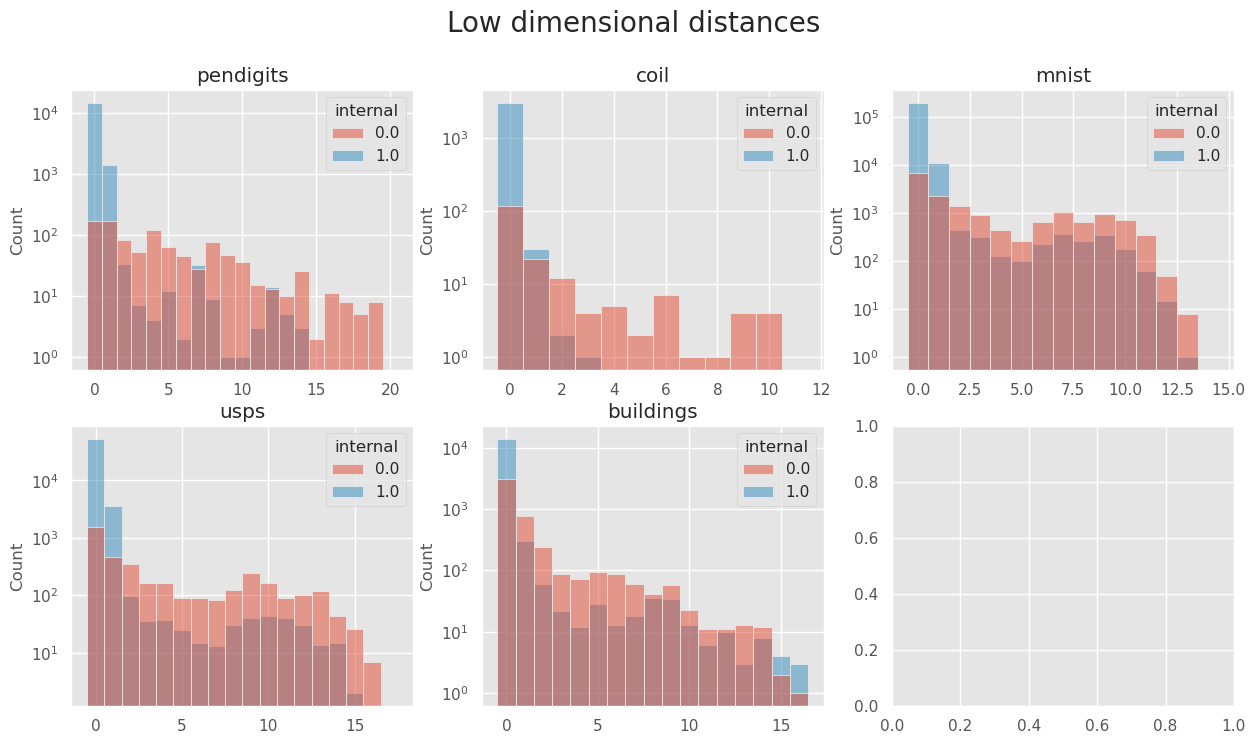

In [125]:
barPlot_split_on3(what='lowdim_dist', what_data=data_set_list[0:5], split_on='internal', edge_df=edge_df, nb_cols=3, log_scale=(False, True))
plt.savefig(F'figures/edge_lowdim_dist.png',bbox_inches='tight')
plt.show()

# Run the same analysis on all other datasets

In [75]:
def plot_histograms(dataset_id, what_vars_to_plot, set_op_mix_ratio=1):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
    umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
    
    G = enrich_graph_edge_properties(G, 
                                 vertex_high_representation=raw_data, 
                                 vertex_low_representation=umap_rep)
    edge_df = G.get_edge_dataframe()
    
    display(Markdown(f'### Comparing internal vs external edges (w.r.t. ground-truth)'))
    barPlot_split_on2(what = what_vars_to_plot,
                 split_on='internal', 
                 edge_df=edge_df,
                     log_scale=(False, True),  nb_cols=2)
    plt.savefig(F'figures/edge_properties_{dataset_name}.png',bbox_inches='tight')
    plt.show()

## pendigits

### Comparing internal vs external edges (w.r.t. ground-truth)

Counter({True: 16136, False: 983})


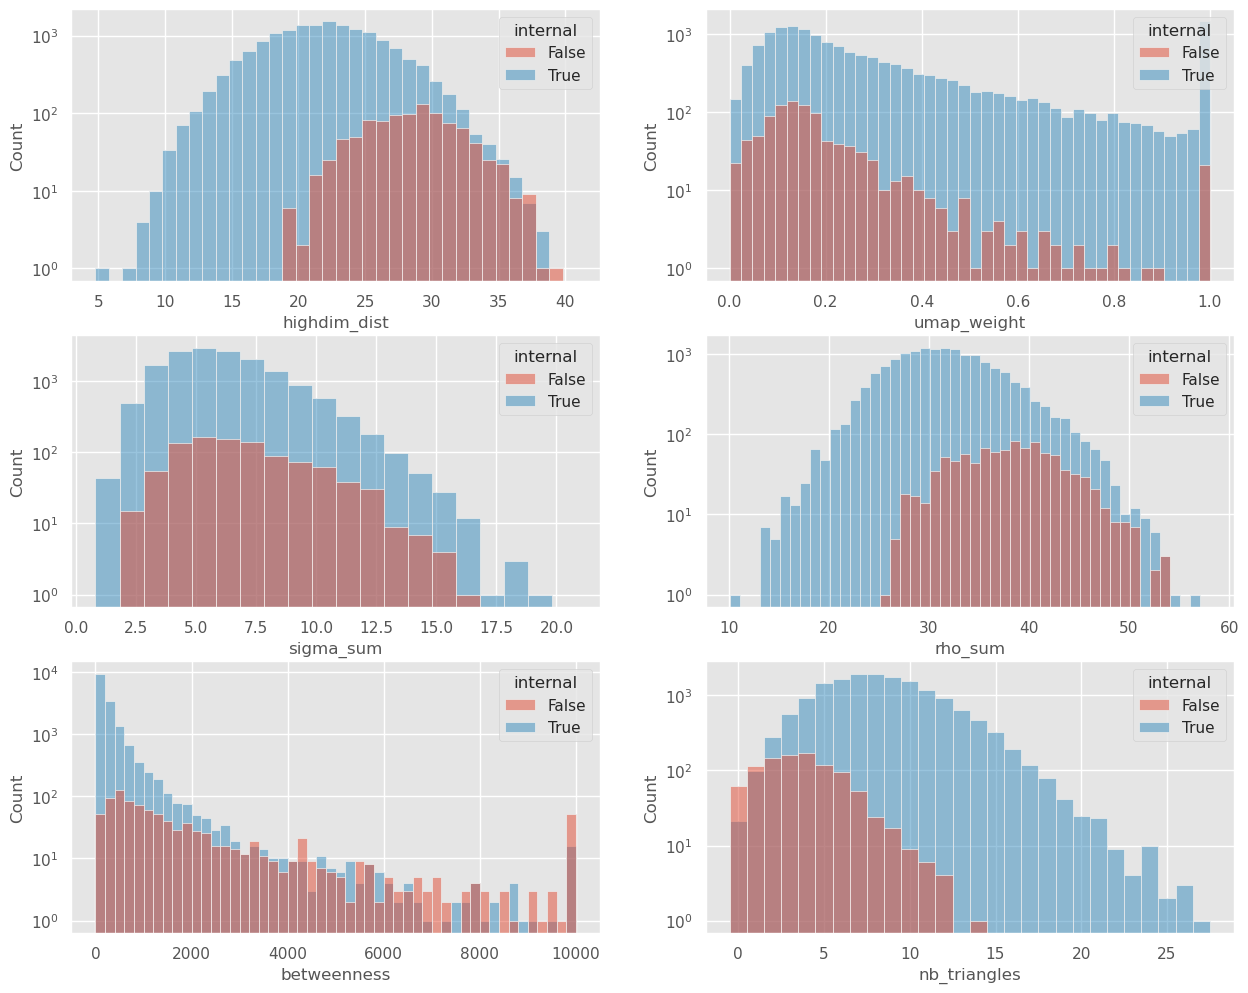

## coil

### Comparing internal vs external edges (w.r.t. ground-truth)

Counter({True: 3117, False: 181})


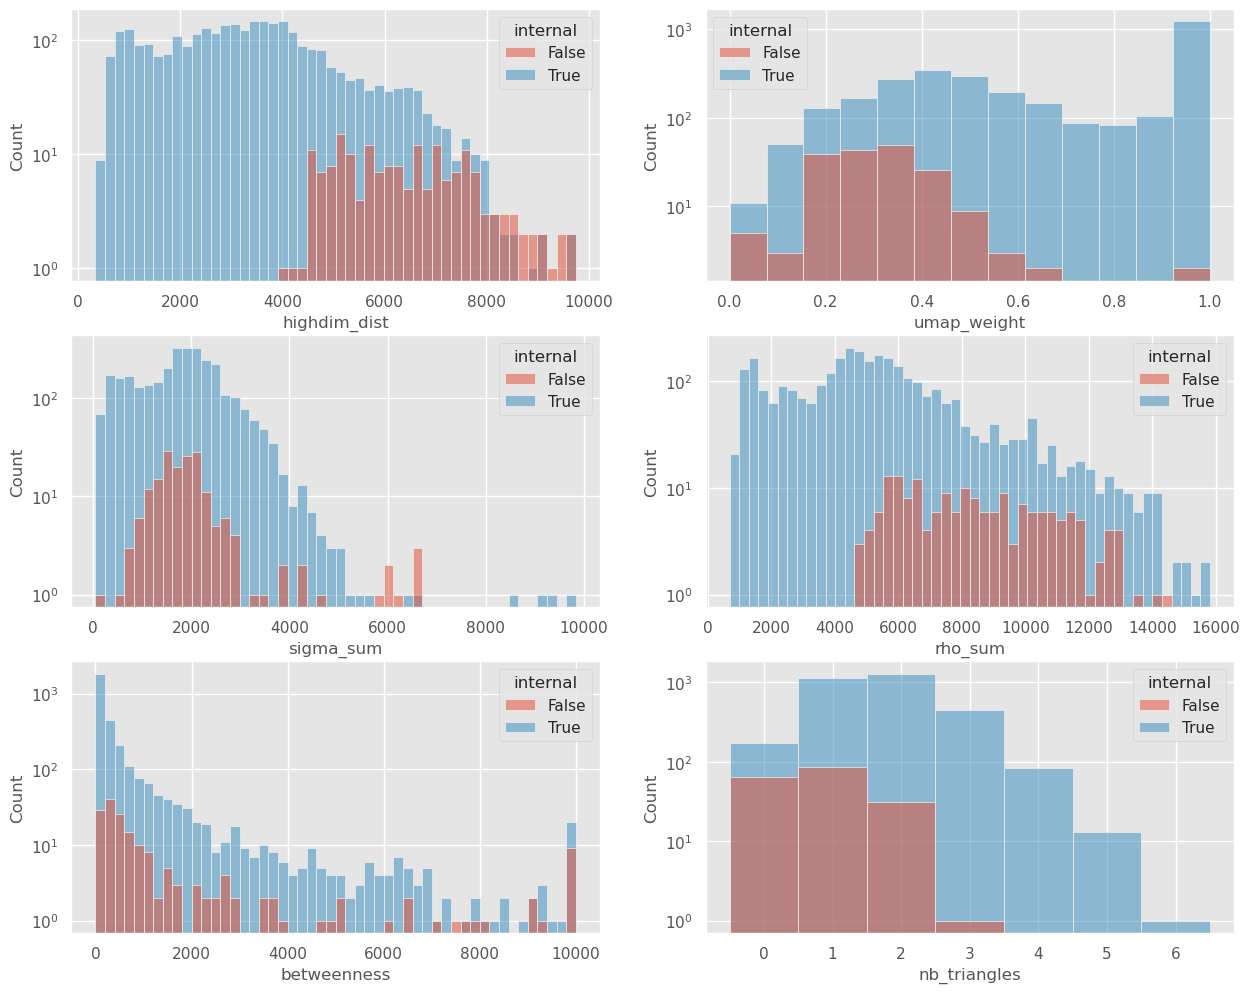

## mnist

### Comparing internal vs external edges (w.r.t. ground-truth)

Counter({True: 216465, False: 16646})


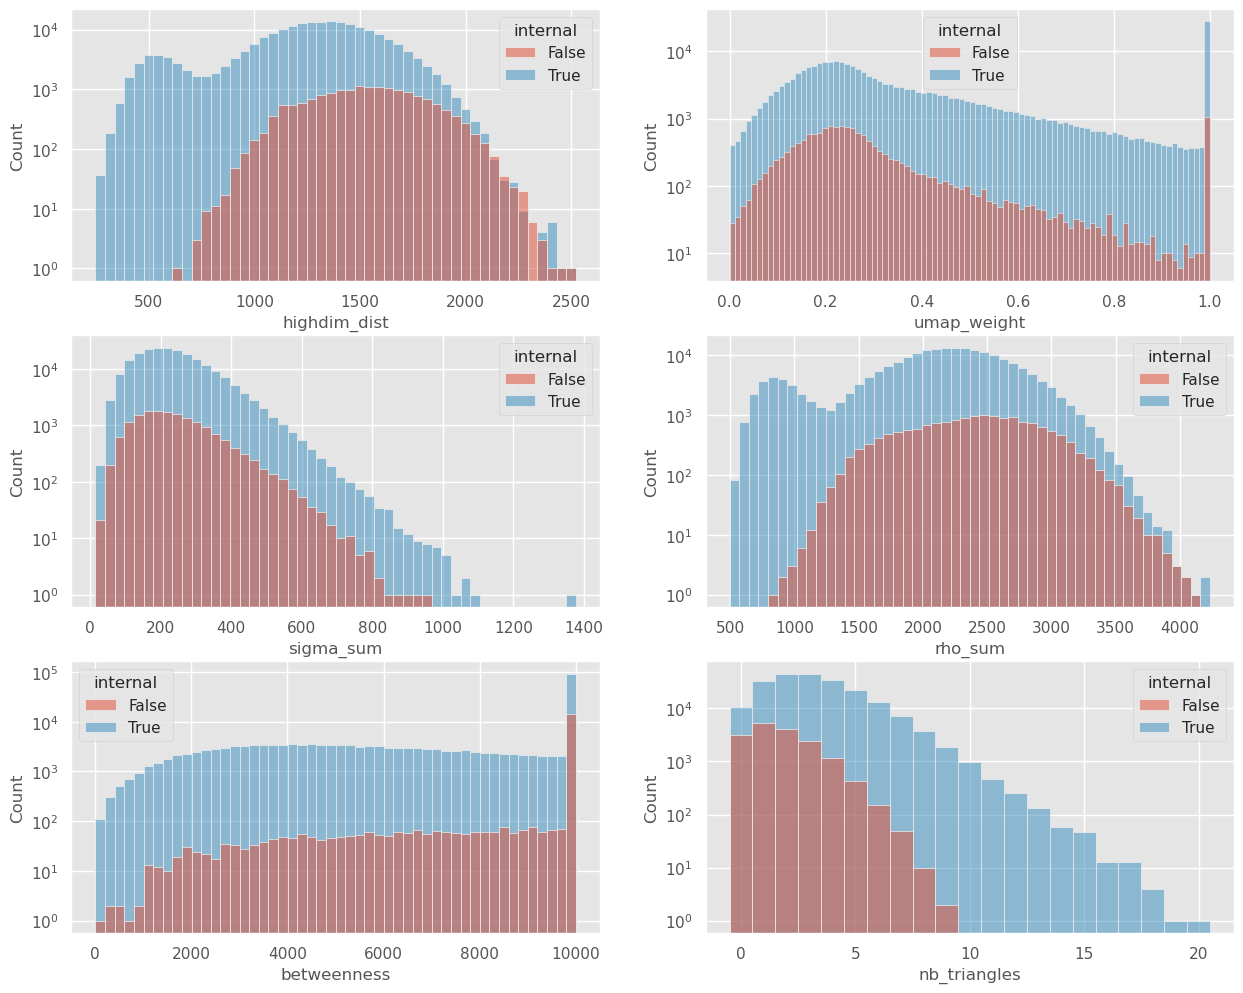

## usps

### Comparing internal vs external edges (w.r.t. ground-truth)

Counter({True: 57731, False: 3902})


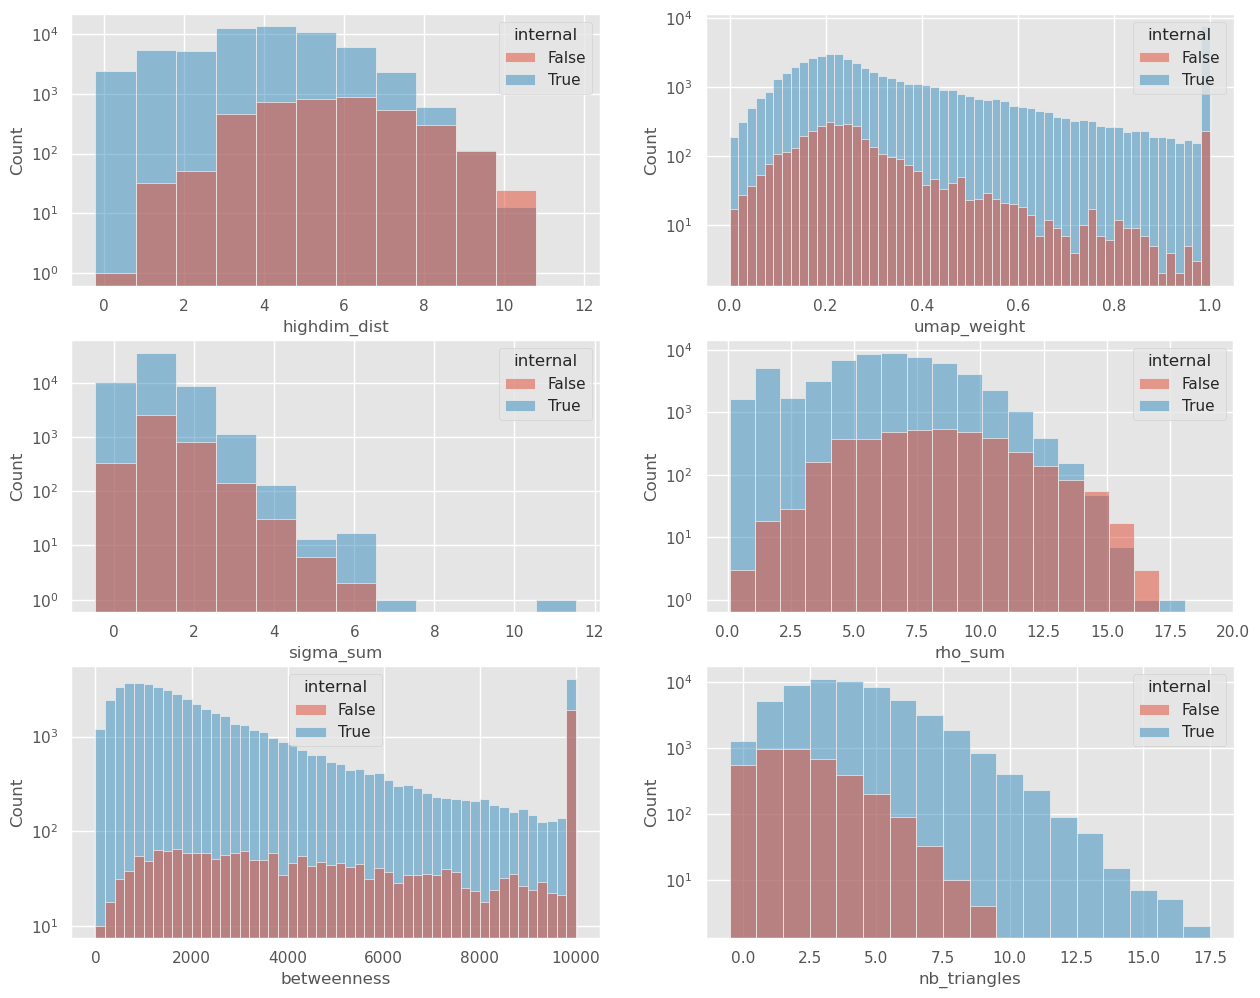

## buildings

### Comparing internal vs external edges (w.r.t. ground-truth)

Counter({True: 14635, False: 4675})


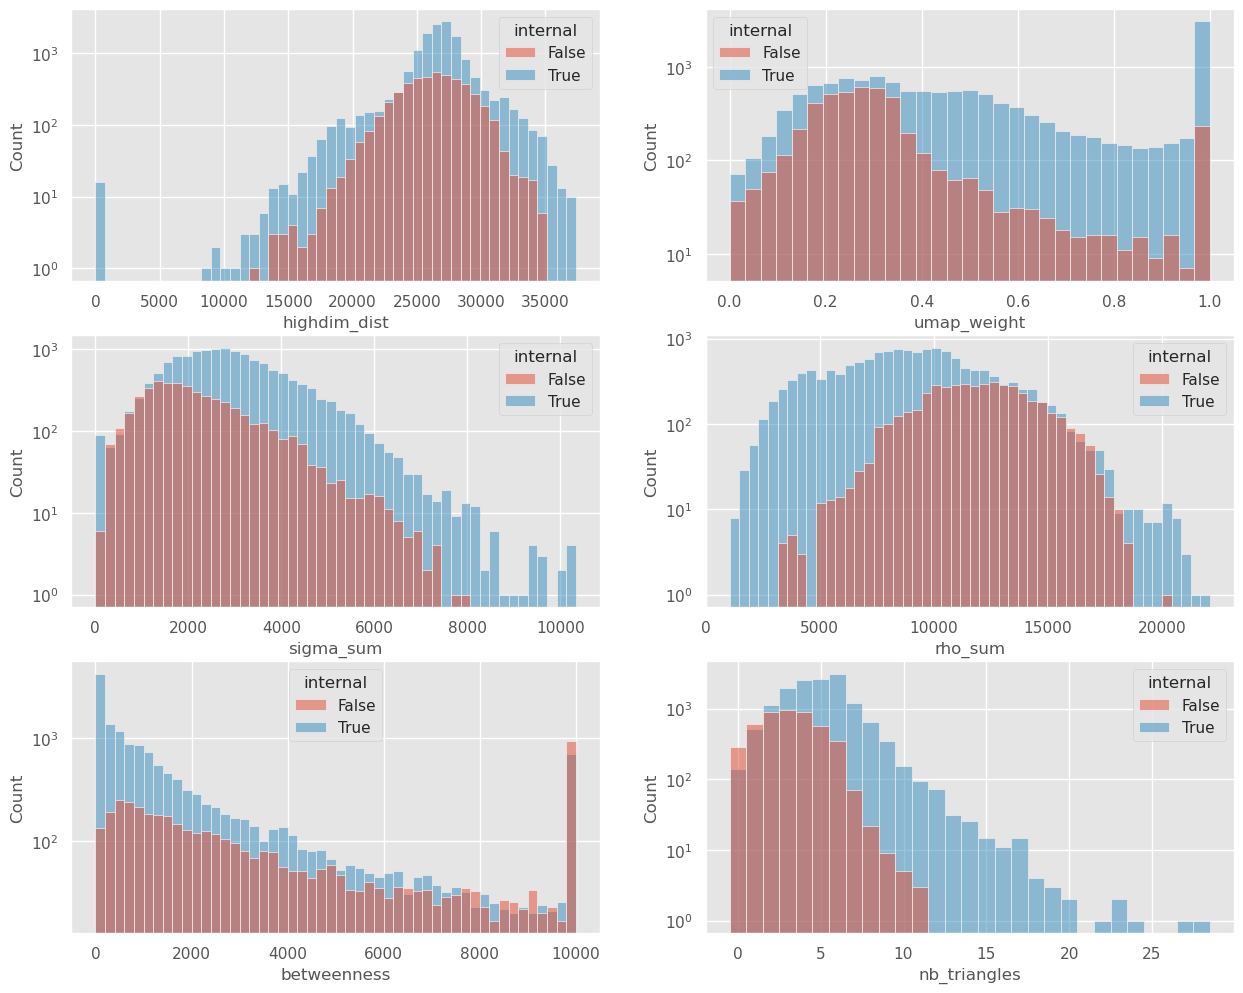

In [76]:
what_vars_to_plot = ['highdim_dist', 'umap_weight', 'sigma_sum', 'rho_sum', 'betweenness', 'nb_triangles', ]
for dataset_id in [0, 1,2,3,4]:
    plot_histograms(dataset_id, what_vars_to_plot, set_op_mix_ratio=1)

In [14]:
def what_we_do_here(dataset_id, what_vars_to_plot, set_op_mix_ratio=1):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')

    umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
    hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)
    G = graph_edge_class_from_labels(G, hd_umap_labels, attribute_name = 'hd_internal')
    
    ec = la.find_partition(G, la.ModularityVertexPartition)
    clustering_labels = np.array(ec.membership)
    G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')
    
    G = enrich_graph_edge_properties(G, 
                                 vertex_high_representation=raw_data, 
                                 vertex_low_representation=umap_rep)
    edge_df = G.get_edge_dataframe()
    edge_df['true_vs_hd'] = list(zip(edge_df.internal, edge_df.hd_internal))
    edge_df['true_vs_leiden'] = list(zip(edge_df.internal, edge_df.leiden_internal))
    mapping = {(True, True):'True pos', (False, False):'True neg', (True, False):'False neg', (False, True):'False pos'}
    edge_df['HDBSCAN'] = [mapping[x] for x in edge_df['true_vs_hd']]
    edge_df['Leiden'] = [mapping[x] for x in edge_df['true_vs_leiden']]
    
    display(Markdown(f'### Comparing internal vs external edges (w.r.t. ground-truth)'))
    barPlot_split_on(what = what_vars_to_plot,
                 split_on='internal', 
                 edge_df=edge_df)
    plt.show()
    
    display(Markdown(f'### HDBSCAN edge classification'))    
    barPlot_split_on(what = what_vars_to_plot,
                 split_on='HDBSCAN', edge_df=edge_df)
    plt.show()
    
    display(Markdown(f'### Leiden edge classification'))    
    barPlot_split_on(what = what_vars_to_plot,
                 split_on='Leiden', edge_df=edge_df)
    plt.show()

## pendigits

### Comparing internal vs external edges (w.r.t. ground-truth)

Counter({True: 16136, False: 983})


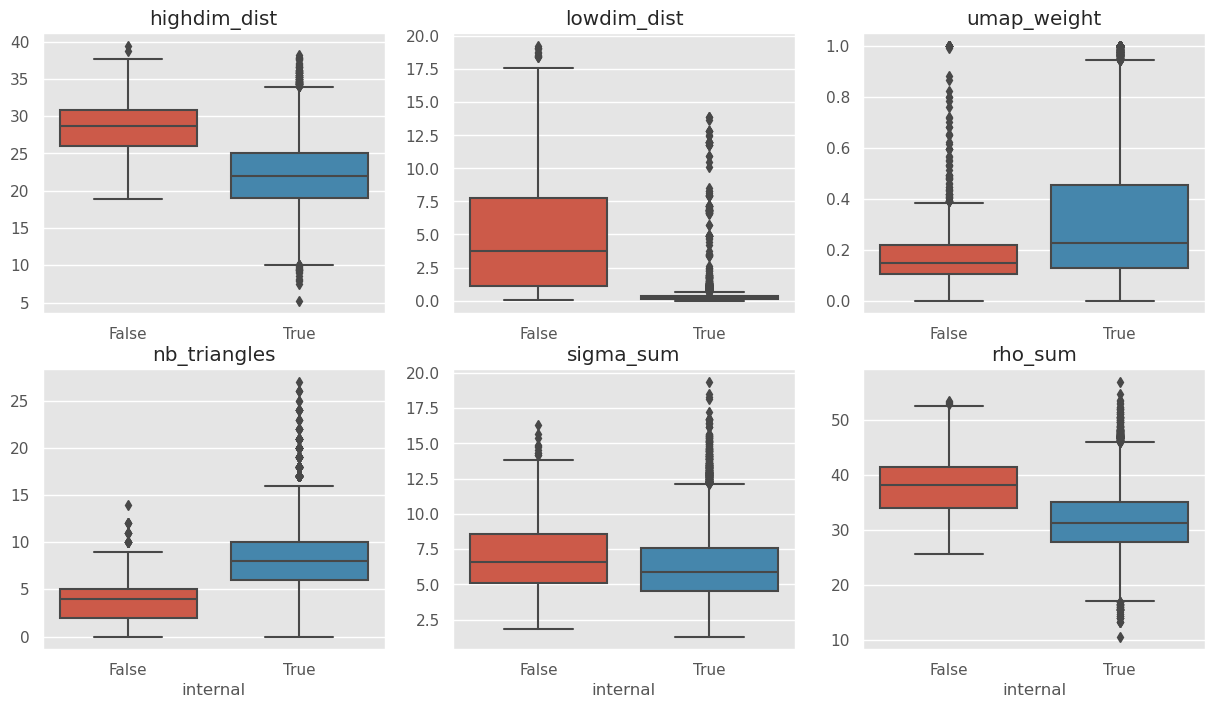

### HDBSCAN edge classification

Counter({'True pos': 16025, 'True neg': 725, 'False pos': 258, 'False neg': 111})


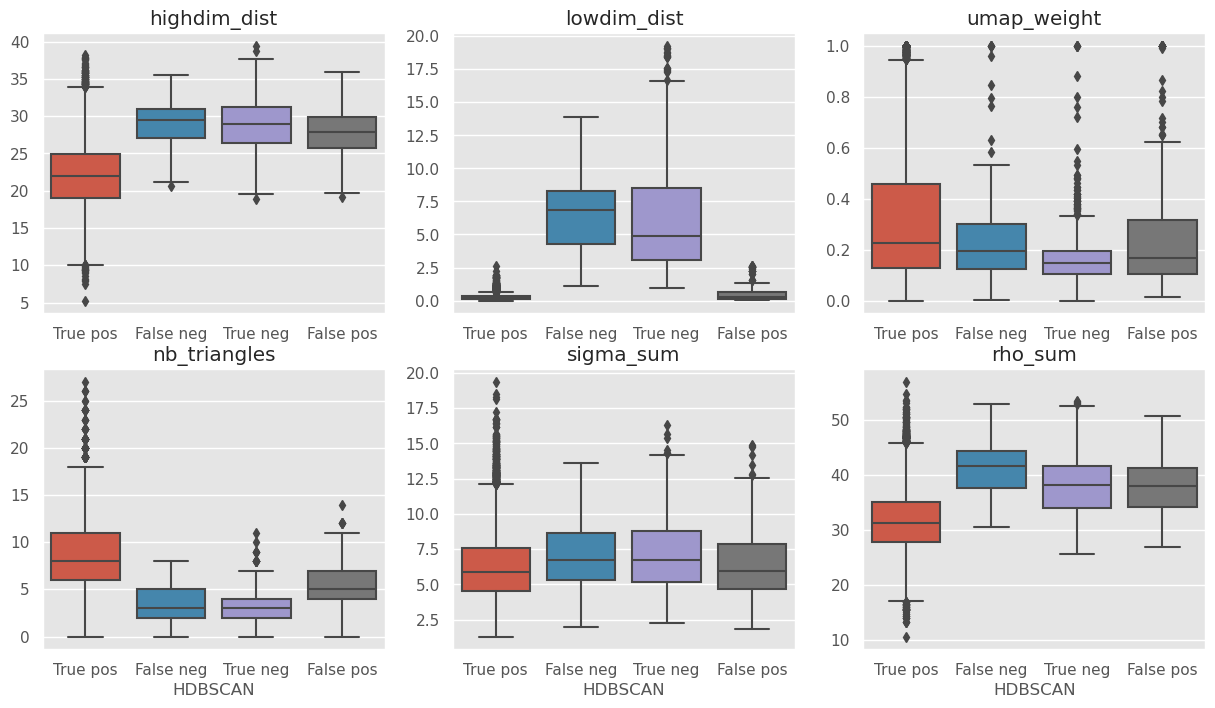

### Leiden edge classification

Counter({'True pos': 15930, 'True neg': 598, 'False pos': 385, 'False neg': 206})


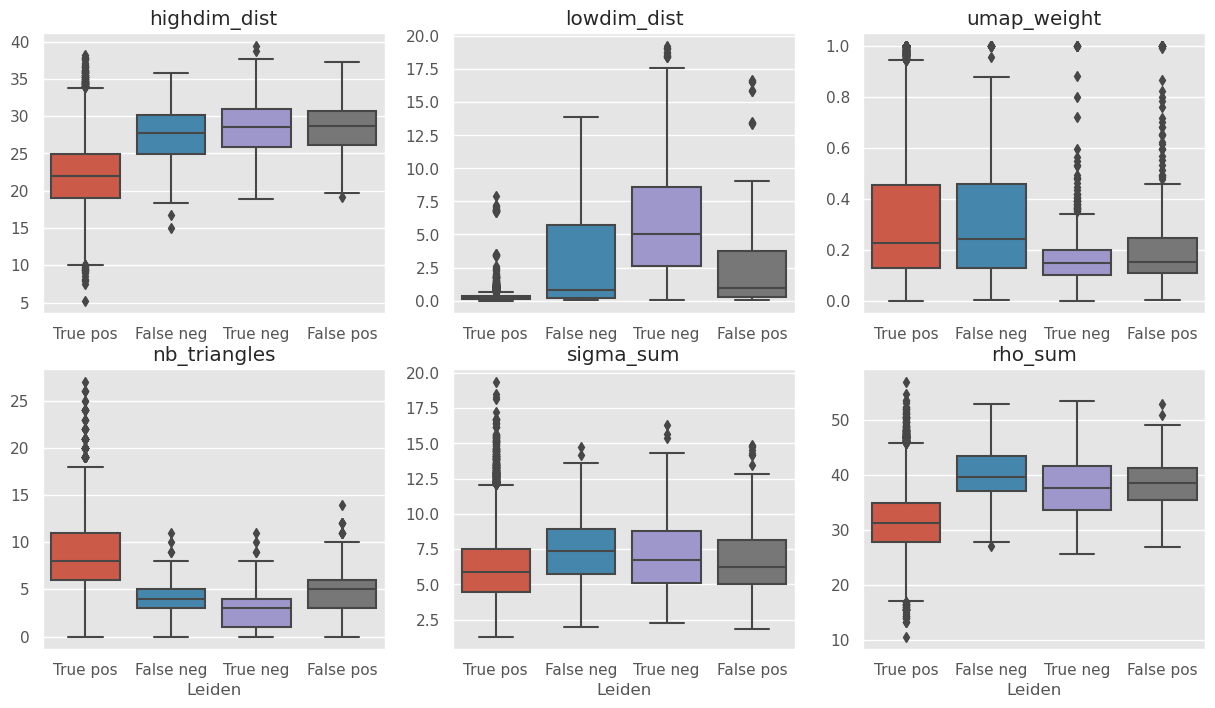

## coil

### Comparing internal vs external edges (w.r.t. ground-truth)

Counter({True: 3117, False: 181})


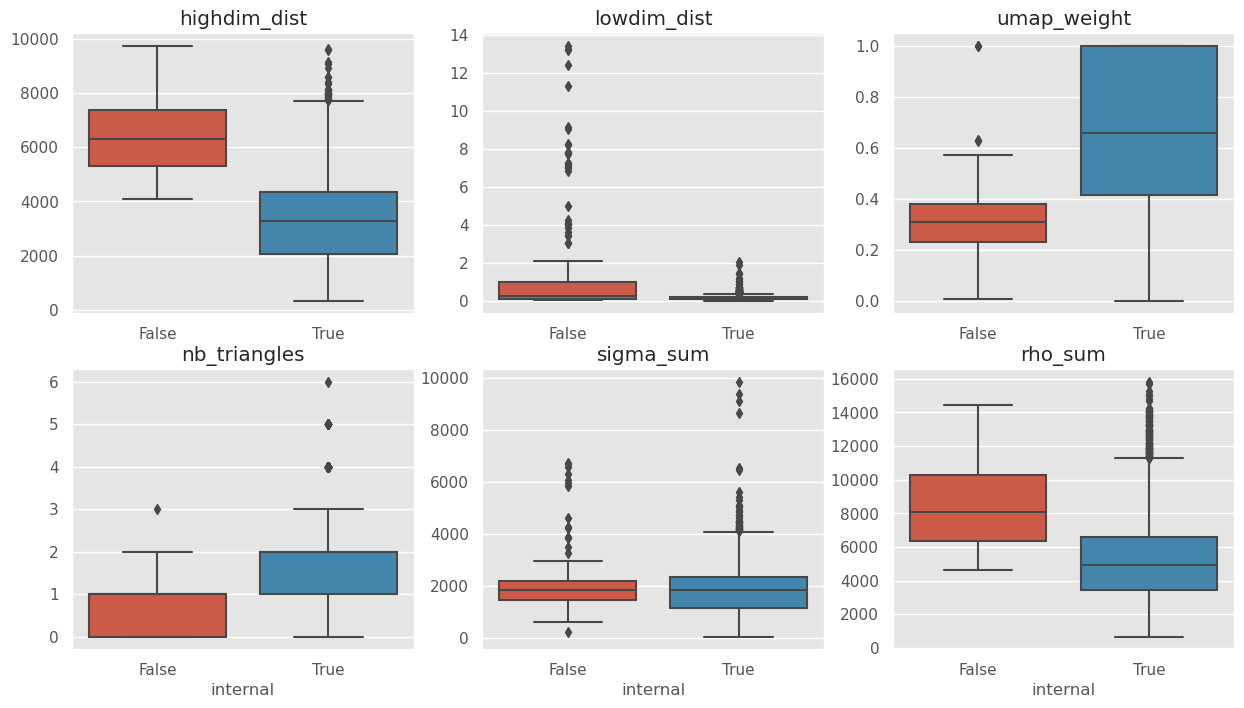

### HDBSCAN edge classification

Counter({'True pos': 3107, 'False pos': 143, 'True neg': 38, 'False neg': 10})


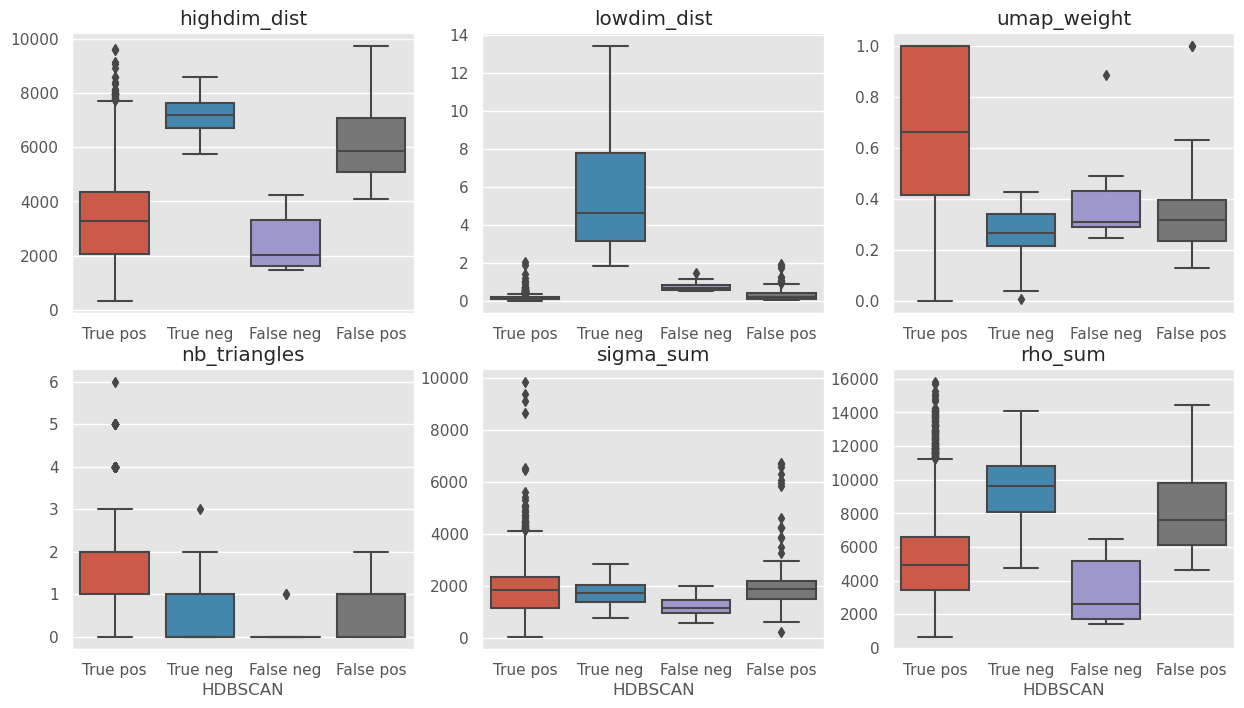

### Leiden edge classification

Counter({'True pos': 3056, 'False pos': 167, 'False neg': 61, 'True neg': 14})


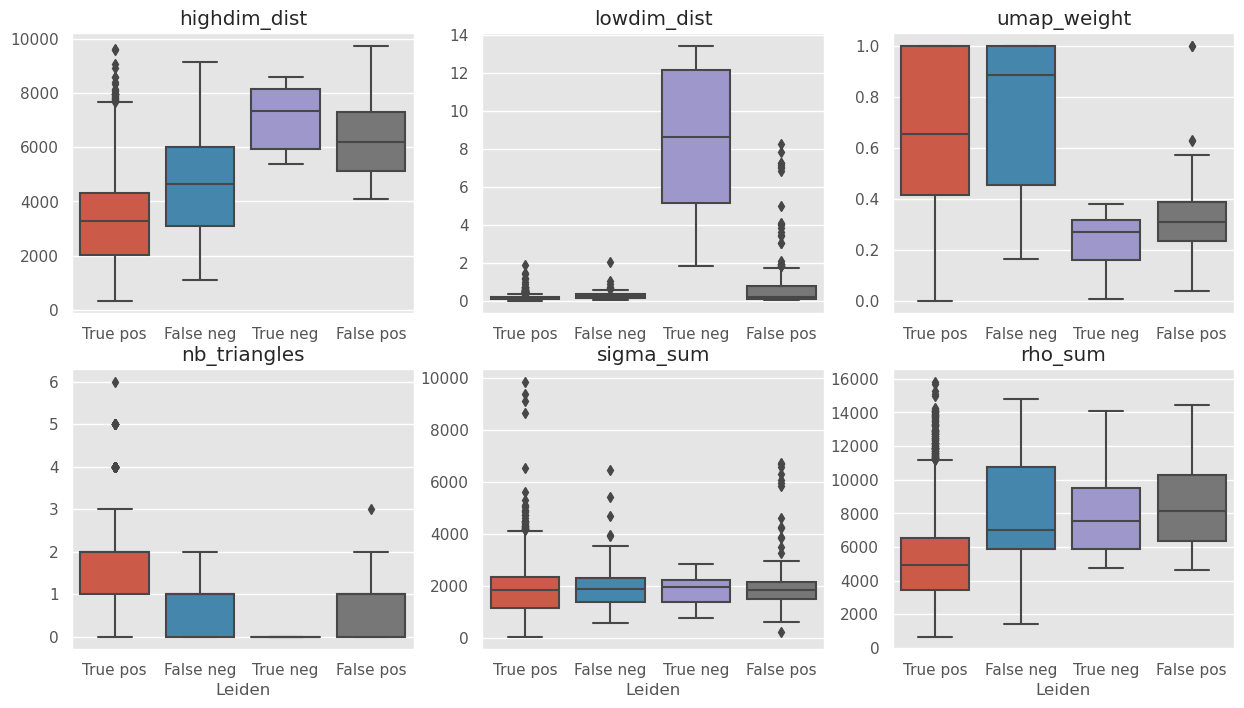

## mnist

### Comparing internal vs external edges (w.r.t. ground-truth)

Counter({True: 216465, False: 16646})


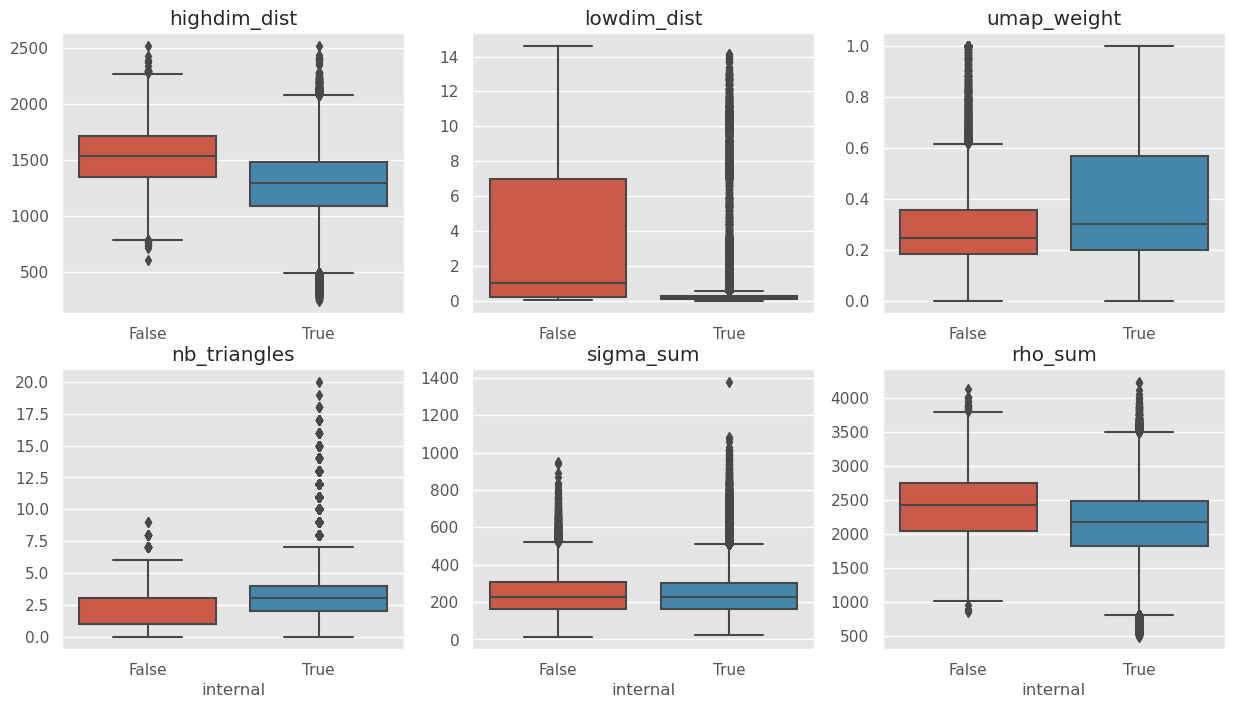

### HDBSCAN edge classification

Counter({'True pos': 212871, 'True neg': 9062, 'False pos': 7584, 'False neg': 3594})


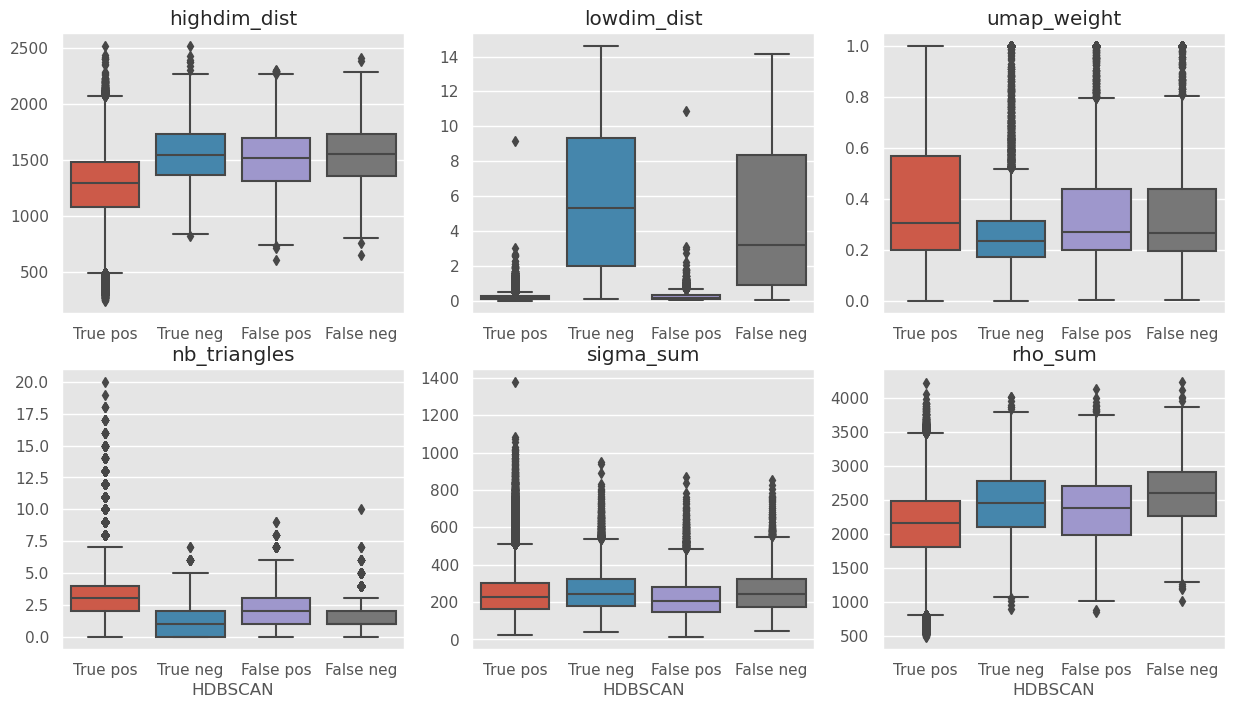

### Leiden edge classification

Counter({'True pos': 210362, 'False pos': 9325, 'True neg': 7321, 'False neg': 6103})


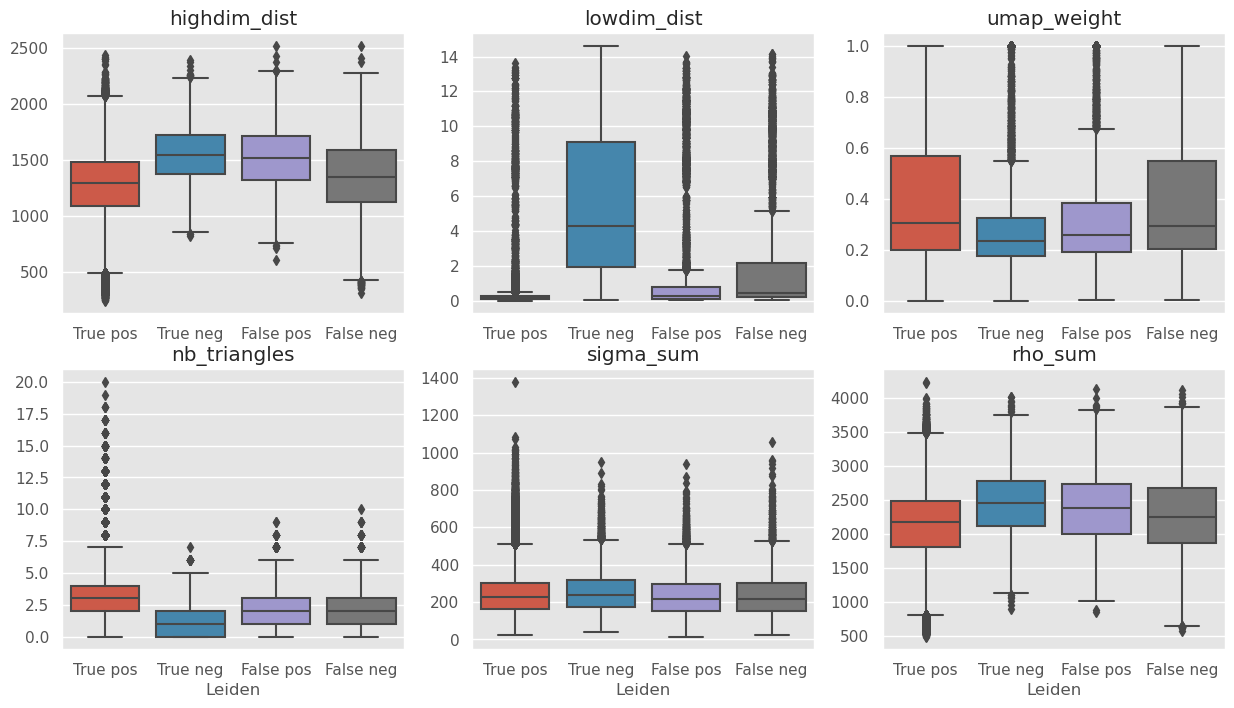

## usps

### Comparing internal vs external edges (w.r.t. ground-truth)

Counter({True: 57731, False: 3902})


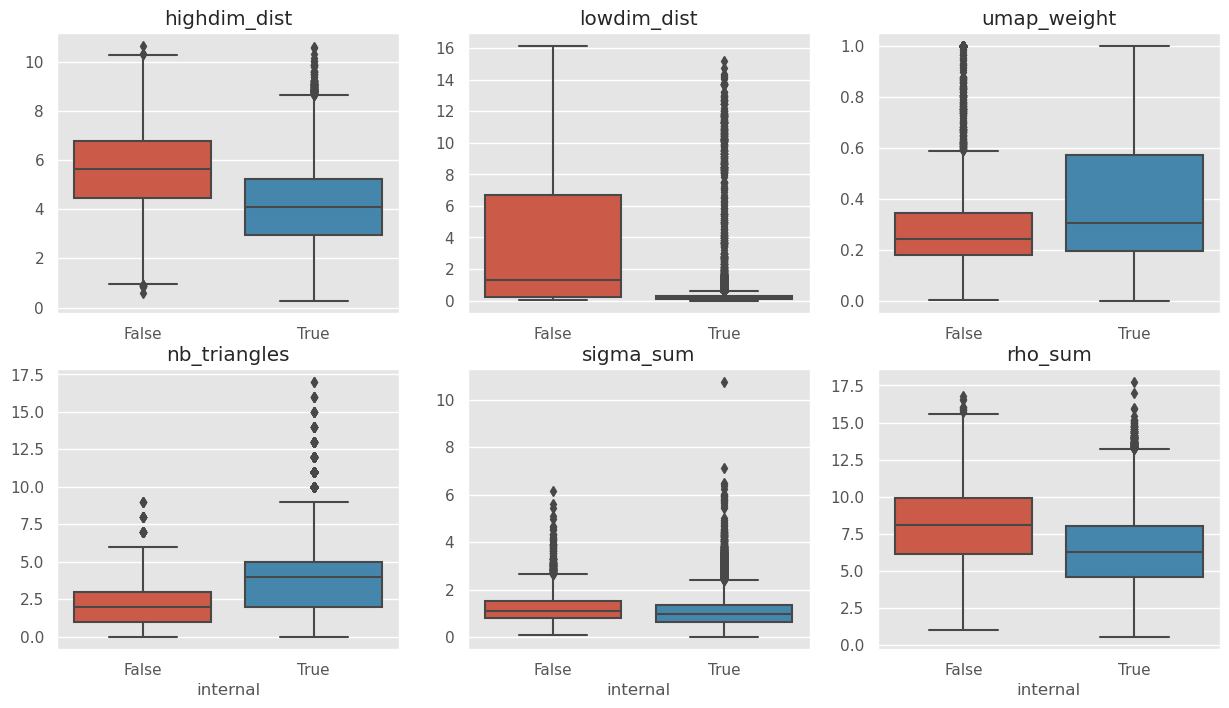

### HDBSCAN edge classification

Counter({'True pos': 57258, 'False pos': 2010, 'True neg': 1892, 'False neg': 473})


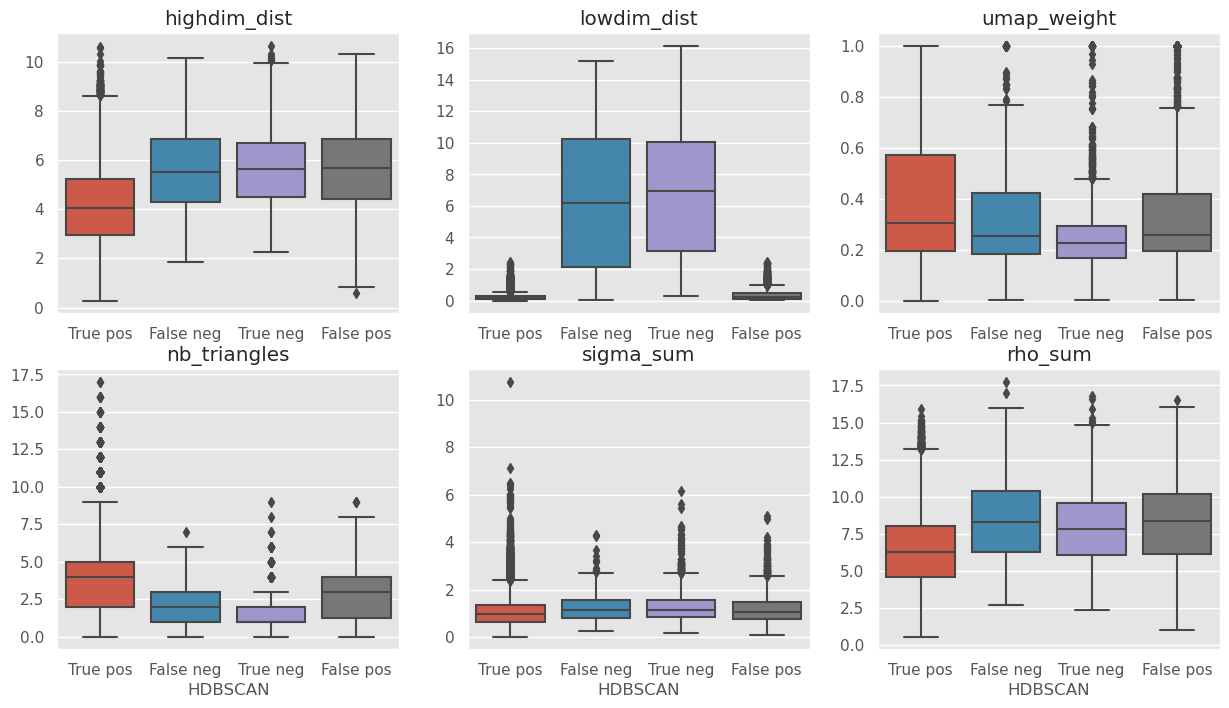

### Leiden edge classification

Counter({'True pos': 56313, 'False pos': 2017, 'True neg': 1885, 'False neg': 1418})


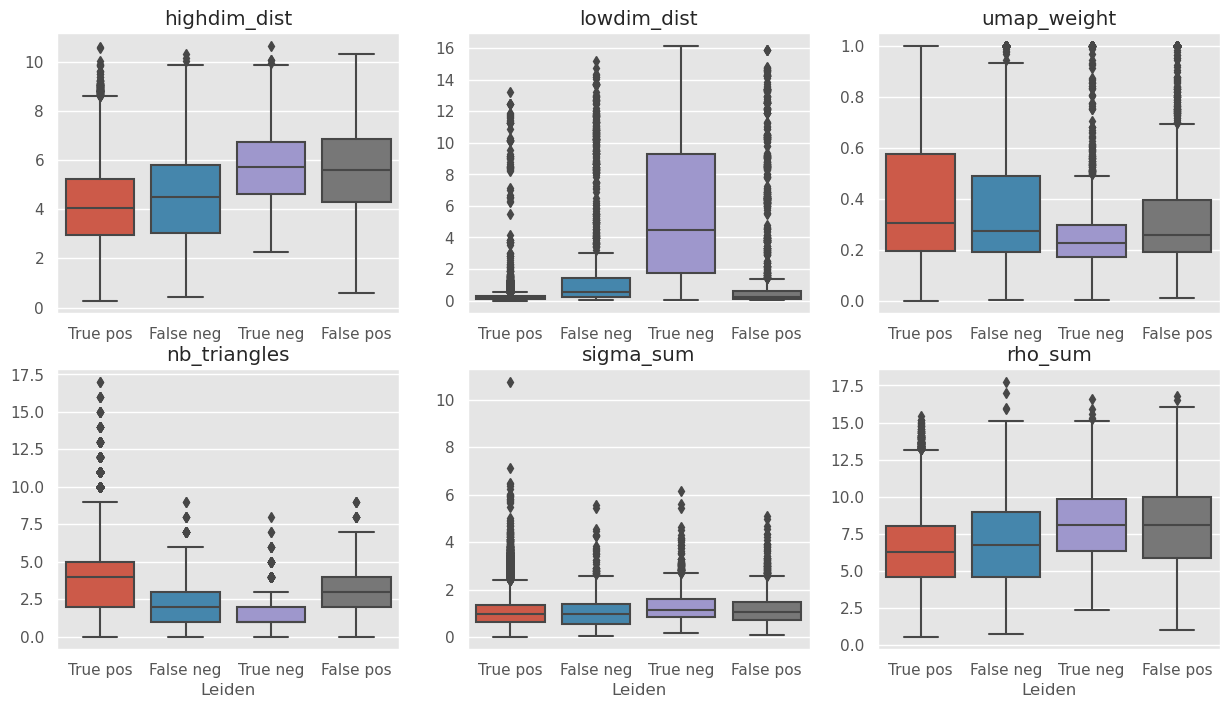

## buildings

### Comparing internal vs external edges (w.r.t. ground-truth)

Counter({True: 14627, False: 4696})


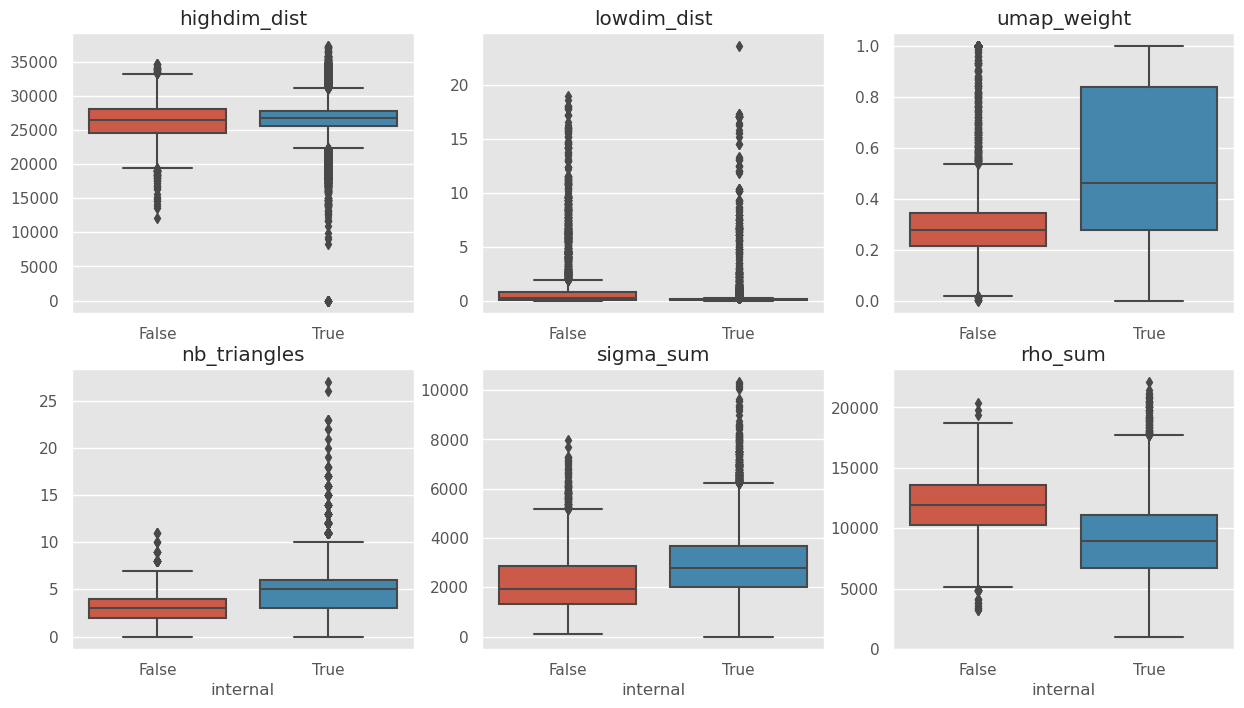

### HDBSCAN edge classification

Counter({'True pos': 13970, 'False pos': 3007, 'True neg': 1689, 'False neg': 657})


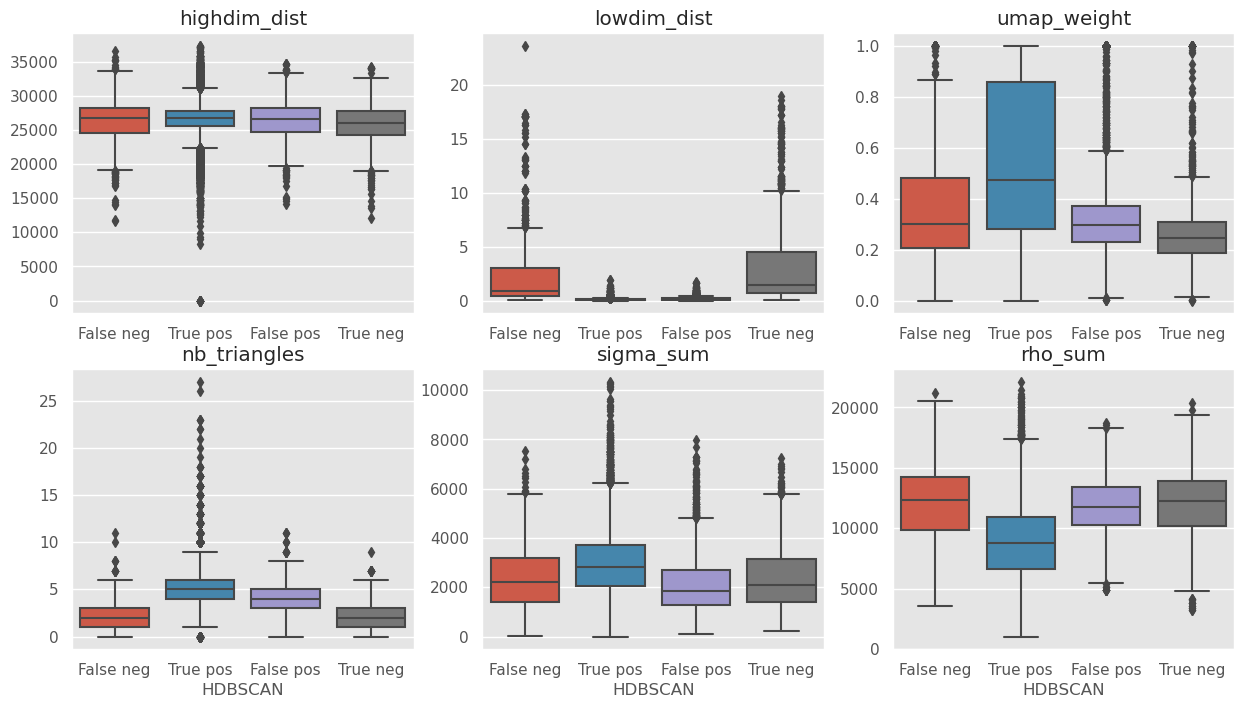

### Leiden edge classification

Counter({'True pos': 14092, 'False pos': 3831, 'True neg': 865, 'False neg': 535})


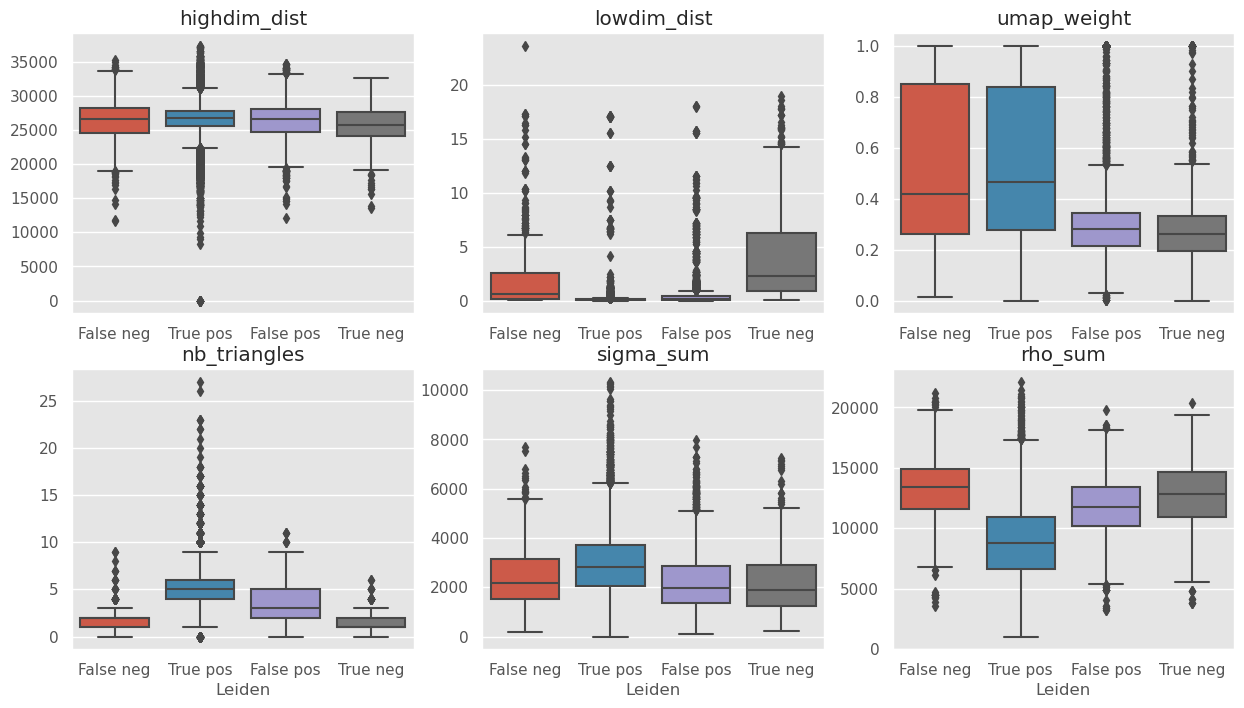

In [15]:
what_vars_to_plot = ['highdim_dist', 'lowdim_dist', 'umap_weight', 'nb_triangles', 'sigma_sum', 'rho_sum']
for dataset_id in [0, 1,2,3,4]:
    what_we_do_here(dataset_id, what_vars_to_plot, set_op_mix_ratio=1)

# More discriminant weights?

## buildings

### Comparing internal vs external edges (w.r.t. ground-truth)

Counter({True: 14627, False: 4696})


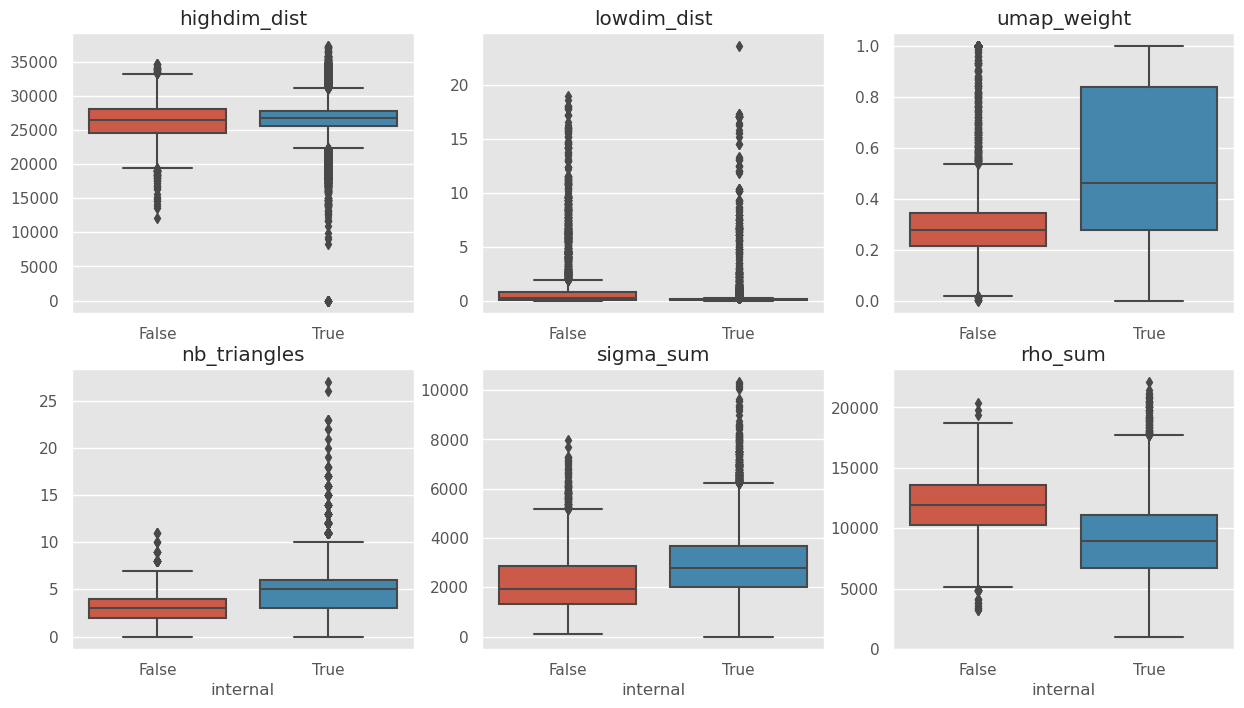

### HDBSCAN edge classification

Counter({'True pos': 13970, 'False pos': 3007, 'True neg': 1689, 'False neg': 657})


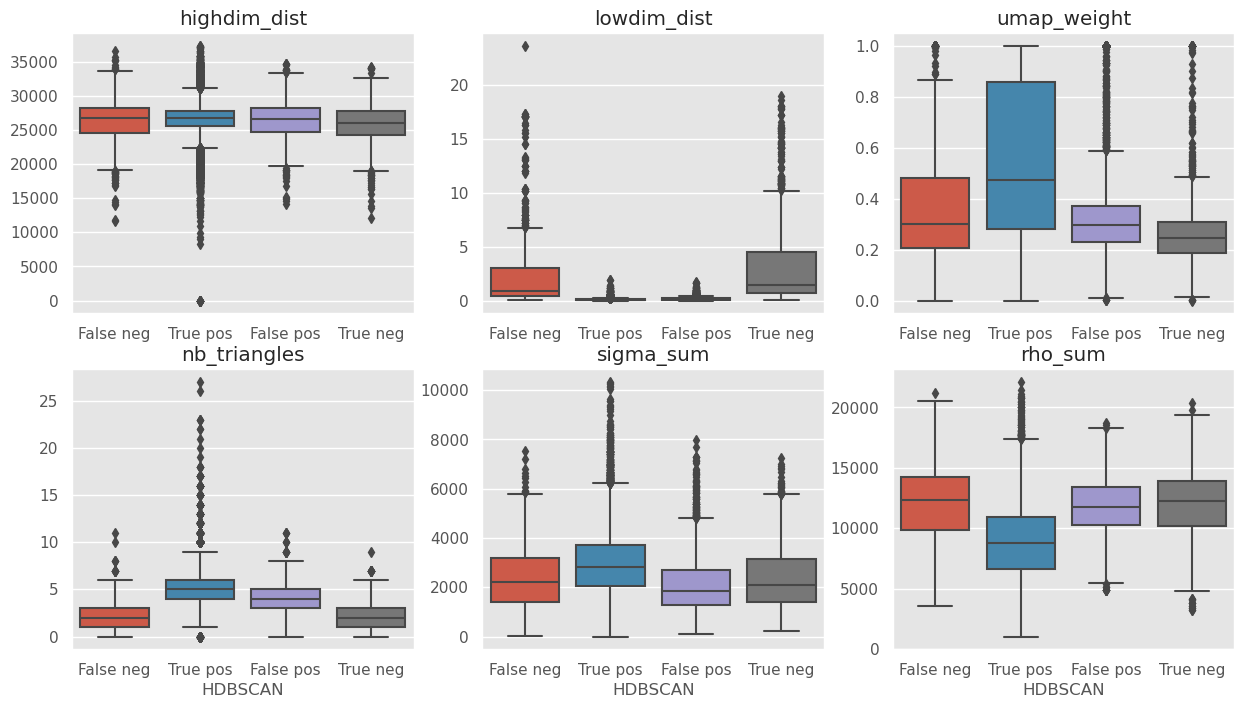

### Leiden edge classification

Counter({'True pos': 14081, 'False pos': 3876, 'True neg': 820, 'False neg': 546})


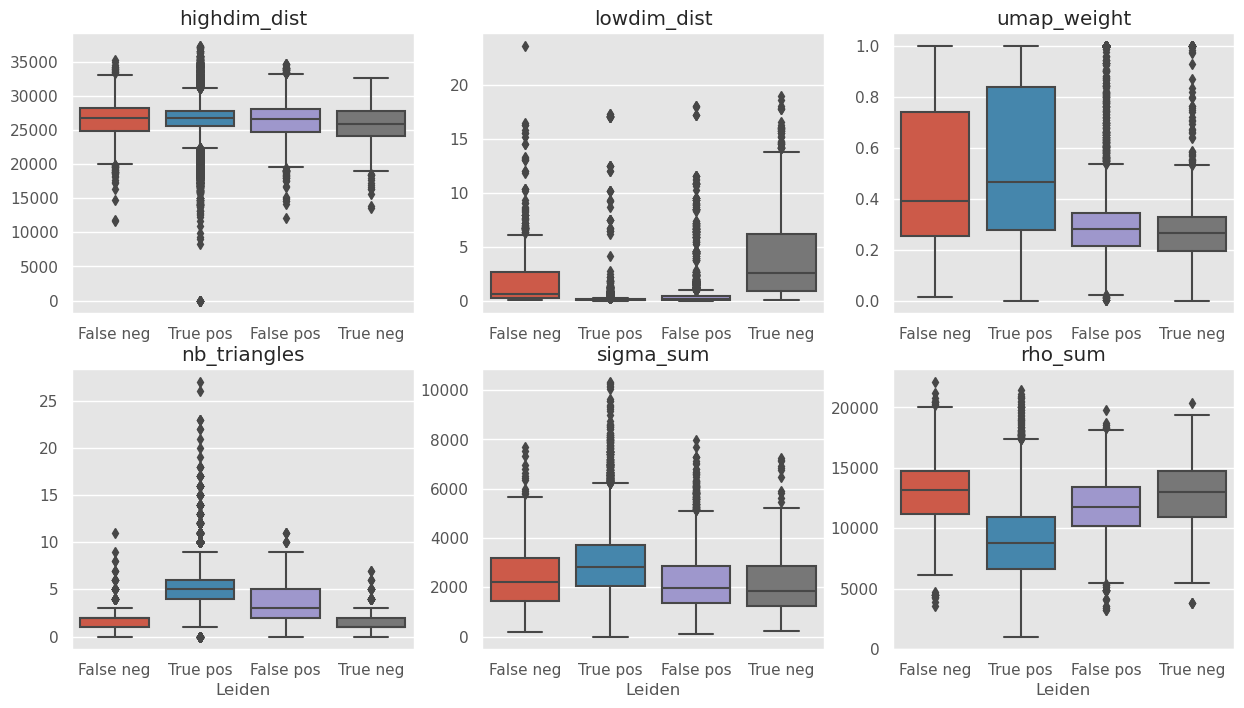

In [16]:
dataset_id=4
what_we_do_here(dataset_id, what_vars_to_plot, set_op_mix_ratio=1)

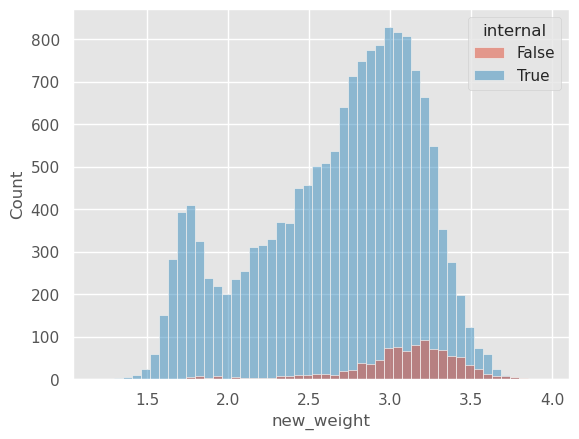

In [17]:
edge_df['new_weight'] = np.log(edge_df['rho_sum'])/(edge_df['umap_weight']+1)
#sns.scatterplot(edge_df, x='rho_sum', y='new_weight', hue='internal')
sns.histplot(edge_df, x='new_weight', hue='internal')
G.es['new_weight'] = edge_df.new_weight

<AxesSubplot:xlabel='nb_triangles', ylabel='Count'>

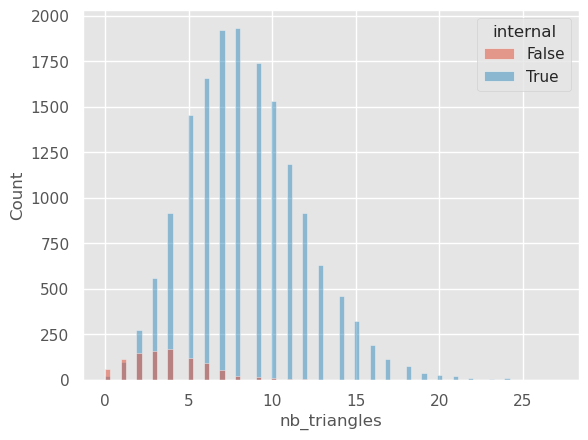

In [20]:
sns.histplot(edge_df, x='nb_triangles', hue='internal')

<AxesSubplot:xlabel='internal', ylabel='new_weight'>

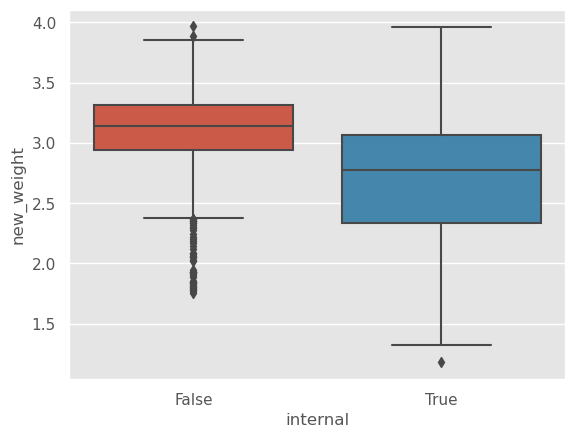

In [21]:
sns.boxplot(x = 'internal', y = 'new_weight', data = edge_df)

# Connectivity of neighborhoods

In [7]:
dataset_id = 0
set_op_mix_ratio = 1
raw_data, targets, dataset_name = get_dataset(dataset_id)
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')

In [22]:
G.es['neigh_connectivity'] = 0
for e in G.es:
    neis_u = G.neighbors(e.target)
    neis_v = G.neighbors(e.source)
    n_uv = G.subgraph(neis_u+neis_v).ecount()
    n_u = G.subgraph(neis_u).ecount()
    n_v = G.subgraph(neis_v).ecount()
    n_inter = len(set(neis_u).intersection(set(neis_v)))
    e['neigh_connectivity'] = n_uv-(n_u+n_v)

<AxesSubplot:xlabel='internal', ylabel='neigh_connectivity'>

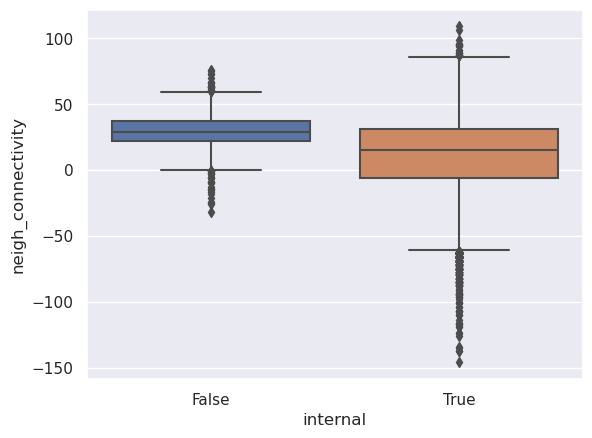

In [23]:
edge_df = G.get_edge_dataframe()
sns.boxplot(data=edge_df, x = 'internal', y = 'neigh_connectivity')

In [18]:
def neighborhood_connectivity(dataset_id):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=1)
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')

    G.es['neigh_connectivity'] = 0
    for e in G.es:
        neis_u = G.neighbors(e.target)
        neis_v = G.neighbors(e.source)
        e['neigh_connectivity'] = G.subgraph(neis_u+neis_v).ecount()-len(neis_u)-len(neis_v)+2*(len(set(neis_u).intersection(set(neis_v))))

    edge_df = G.get_edge_dataframe()
    sns.boxplot(data=edge_df, x = 'internal', y = 'neigh_connectivity')
    plt.show()

## pendigits

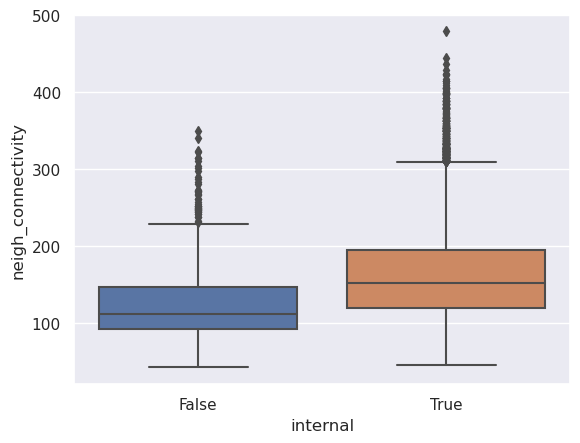

## coil

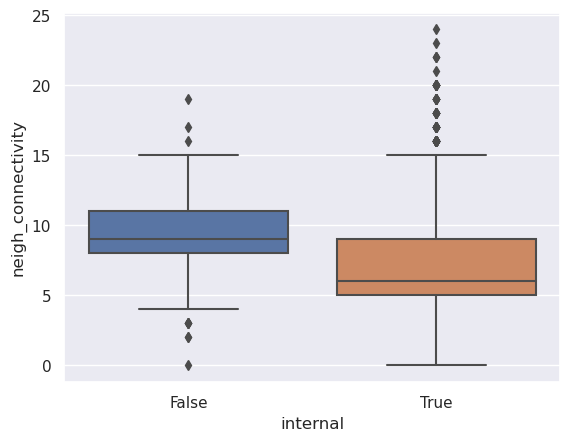

## mnist

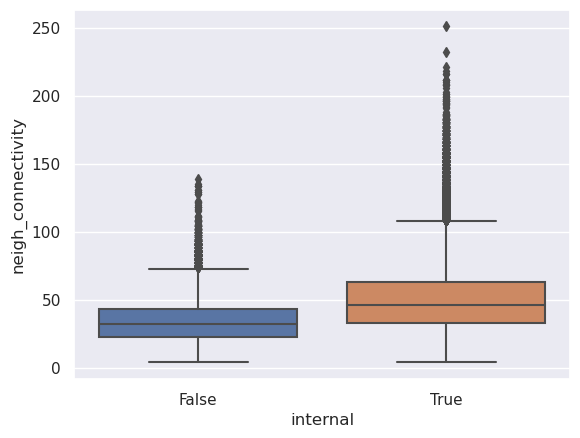

## usps

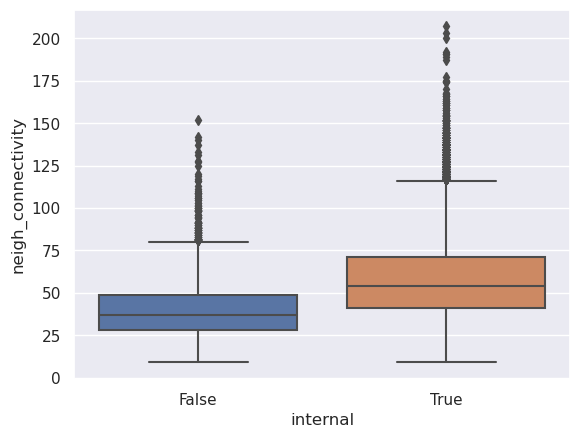

## buildings

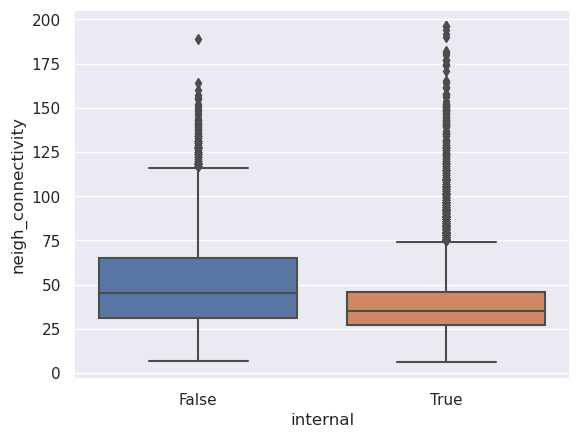

In [19]:
for i in range(5):
    neighborhood_connectivity(dataset_id=i)